In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from minisom import MiniSom

In [2]:
df = pd.read_csv('df_prepared.csv').drop(columns=["Unnamed: 0"])
# Filter out rows where outlier_z_score is True
df = df[df["outlier_z_score"] == False]

#### Task Preprocessing

Prepare the dataset by applying an appropriate normalization method to the variables. <br>
Should you normalize the outcome variable? <br>
Should you use the same method for all variables or decide for each variable individually?

In [3]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Select numerical columns to normalize (excluding Outcome and index columns)
columns_to_normalize = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", 
                         "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

# Apply Min-Max Scaling
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Select only the input variables (excluding Outcome)
features = df.drop(columns=["Outcome", "outlier_Tukey", "outlier_z_score"])

# Create a pairplot
#sns.pairplot(df, hue="Outcome", diag_kind="hist", plot_kws={'alpha':0.5, 's':10})

# Show the plot
#plt.show()

Should You Normalize the Outcome Variable? <br>
No, the Outcome variable should not be normalized because it is a binary categorical variable (0 or 1). Normalization is meant for continuous numerical features to scale them within a range, whereas Outcome already represents a classification label and should remain unchanged.

Should You Use the Same Normalization Method for All Variables? <br>
For consistency, Min-Max scaling is a good choice across all numerical features in this dataset. If you would choose different scaling methods, you might still have the issue that the range in which the data is encountered differs between variables. Variables with in absolute values larger range tend to dominate.

#### Task PCA

1) Perform PCA on all input variables.
2) Use a screeplot and the elbow method to decide how many PCs should be included in further analysis. How much variance is explained by the chosen PCs?
3) Interprete the eigenvectors/loadings of the 2 PCs with the highest eigenvalue. Use a visualization method for explanation.
4) Split the dataset by "Outcome". Perform PCA for both subsets. Are there clearly visible differences in the PCs? What does that mean?

In [4]:
#1
# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(features)

# Convert principal components into a DataFrame
df_pca = pd.DataFrame(principal_components, columns=[f"PC{i+1}" for i in range(principal_components.shape[1])])

# Add back the Outcome column
df_pca["Outcome"] = df["Outcome"].values

# Display the explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the first few rows of the PCA-transformed dataset
print(df_pca.head())

Explained Variance Ratio: [0.31375411 0.18089934 0.1510476  0.10290775 0.08432812 0.07785496
 0.05204545 0.03716266]
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.327141  0.044672  0.079814 -0.036914 -0.109626  0.032174 -0.113731   
1 -0.217488 -0.082501 -0.034060 -0.019017  0.204839  0.228757  0.014829   
2  0.267029  0.132786  0.009591 -0.367875  0.044635 -0.247637  0.005378   
3 -0.375544 -0.151680 -0.083565 -0.010222 -0.012071  0.008554  0.027260   
4 -0.062174 -0.188006 -0.078621 -0.063018 -0.066574 -0.076367  0.041777   

        PC8  Outcome  
0  0.017780        1  
1  0.017783        0  
2  0.068346        1  
3 -0.009120        0  
4  0.080214        0  


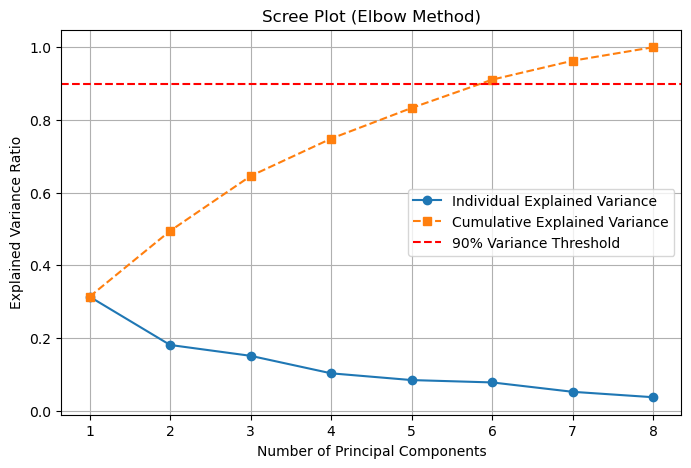

In [5]:
#2
# Compute explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-', label='Individual Explained Variance')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='s', linestyle='--', label='Cumulative Explained Variance')

plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot (Elbow Method)")
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance Threshold")
plt.legend()
plt.grid()

plt.show()

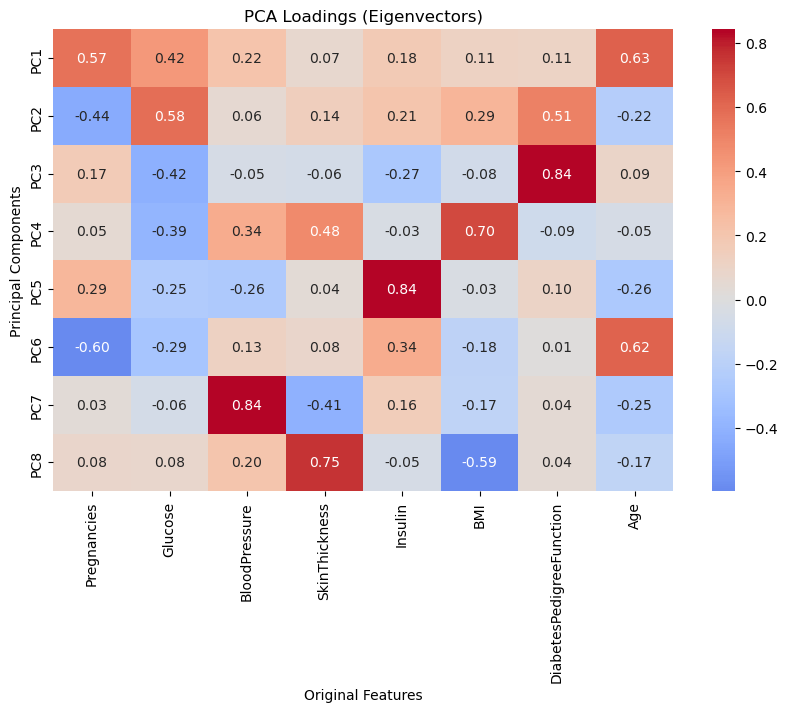

In [6]:
#3 
# Get PCA loadings (eigenvectors)
loadings = pca.components_

# Convert to DataFrame for better visualization
loadings_df = pd.DataFrame(loadings, columns=features.columns, index=[f"PC{i+1}" for i in range(loadings.shape[0])])

# Plot heatmap of PCA loadings
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, annot=True, cmap="coolwarm", center=0, fmt=".2f")

plt.title("PCA Loadings (Eigenvectors)")
plt.xlabel("Original Features")
plt.ylabel("Principal Components")

plt.show()

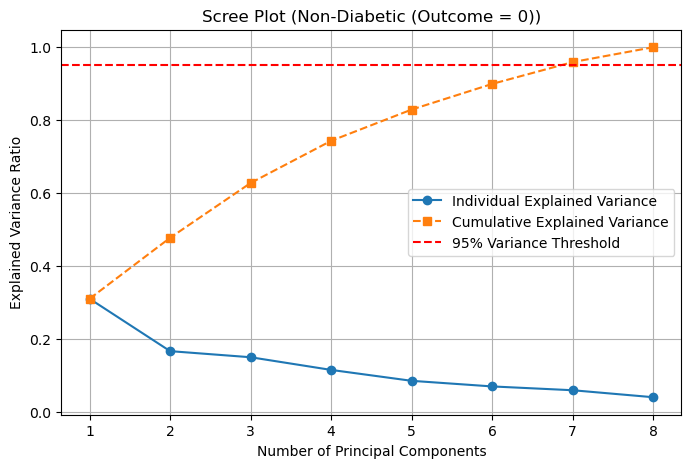

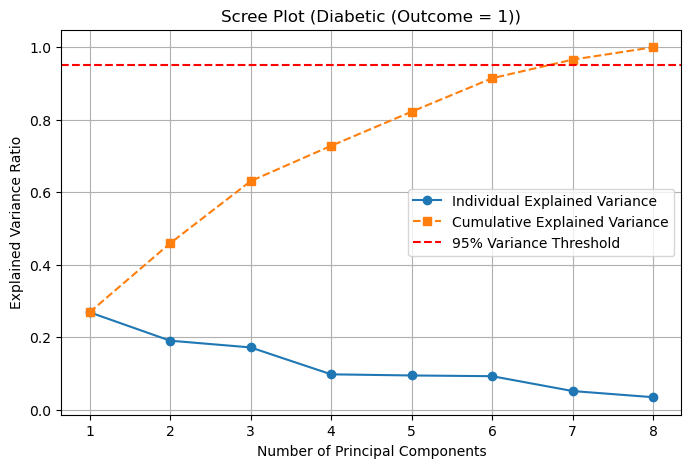

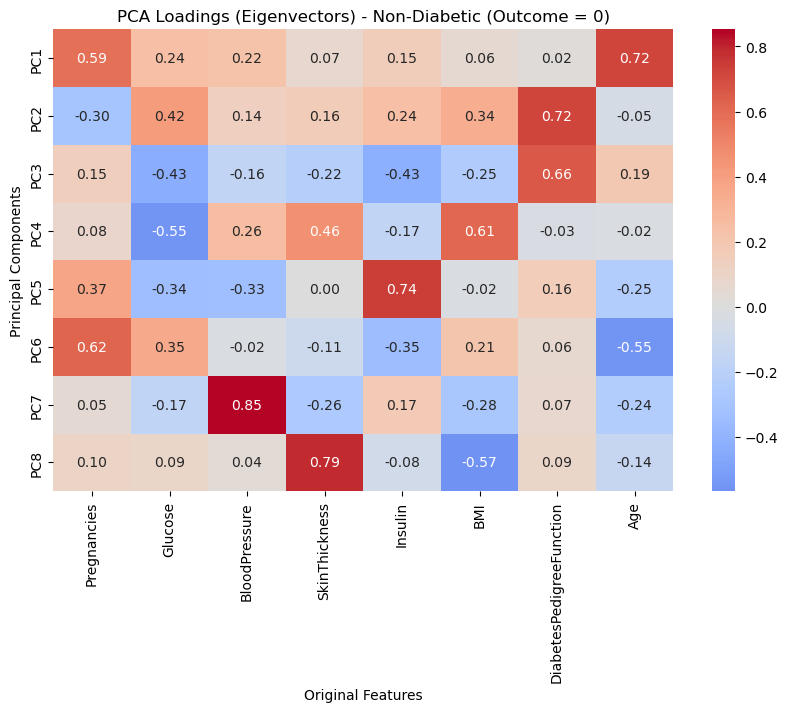

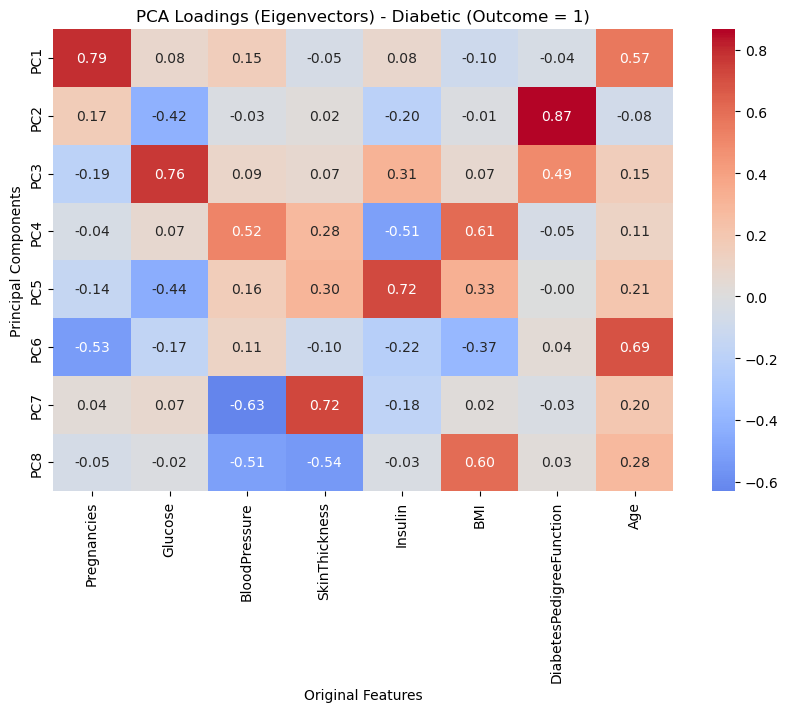

In [7]:
#4 
# Split dataset based on Outcome
df_0 = df[df["Outcome"] == 0].drop(columns=["Outcome", "outlier_Tukey", "outlier_z_score"])  # Non-Diabetic
df_1 = df[df["Outcome"] == 1].drop(columns=["Outcome", "outlier_Tukey", "outlier_z_score"])  # Diabetic

# Perform PCA for Non-Diabetic Group
pca_0 = PCA()
pc_0 = pca_0.fit_transform(df_0)

# Perform PCA for Diabetic Group
pca_1 = PCA()
pc_1 = pca_1.fit_transform(df_1)

# Scree Plot Function
def plot_scree(pca, title):
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-', label='Individual Explained Variance')
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='s', linestyle='--', label='Cumulative Explained Variance')
    
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Explained Variance Ratio")
    plt.title(f"Scree Plot ({title})")
    plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance Threshold")
    plt.legend()
    plt.grid()
    plt.show()

# Scree plots for both groups
plot_scree(pca_0, "Non-Diabetic (Outcome = 0)")
plot_scree(pca_1, "Diabetic (Outcome = 1)")

# Loadings (Eigenvectors) Visualization Function
def plot_loadings(pca, features, title):
    loadings = pca.components_
    loadings_df = pd.DataFrame(loadings, columns=features.columns, index=[f"PC{i+1}" for i in range(loadings.shape[0])])

    plt.figure(figsize=(10, 6))
    sns.heatmap(loadings_df, annot=True, cmap="coolwarm", center=0, fmt=".2f")
    plt.title(f"PCA Loadings (Eigenvectors) - {title}")
    plt.xlabel("Original Features")
    plt.ylabel("Principal Components")
    plt.show()

# Loadings plots for both groups
plot_loadings(pca_0, df_0, "Non-Diabetic (Outcome = 0)")
plot_loadings(pca_1, df_1, "Diabetic (Outcome = 1)")


#### Task K-Means Clustering

Perform the following tasks for the original (but normalized) variables and the PCA/dimension-reduced dataset. Compare how the resulst diverge.
1) Perform K-Means with k=[1:10] clusters. Calculate Sum of Squared Errors and Silhouette Score for each clustering iteration. Visualize the Goodness of Fit for each k as scree plots. Use the Elbow Method to find the optimal number of clusters. Is it the same for both Goodness of Fit methods?
2) Create a brief descriptive overview of the clusters. 
3) Compare if the clusters align with the outcome.

C:\Users\schiltem93\AppData\Local\anaconda3\envs\analytics2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\schiltem93\AppData\Local\anaconda3\envs\analytics2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\schiltem93\AppData\Local\anaconda3\envs\analytics2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\schiltem93\Ap

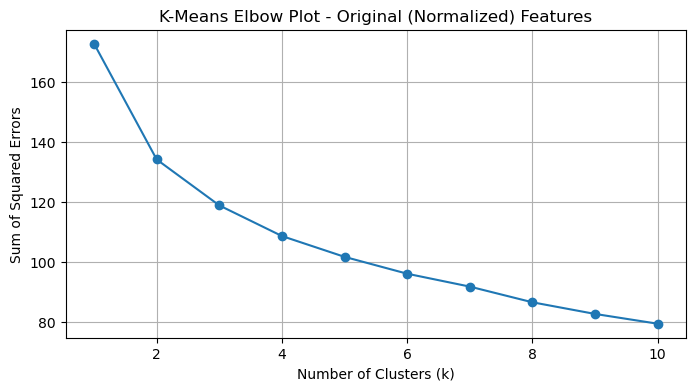

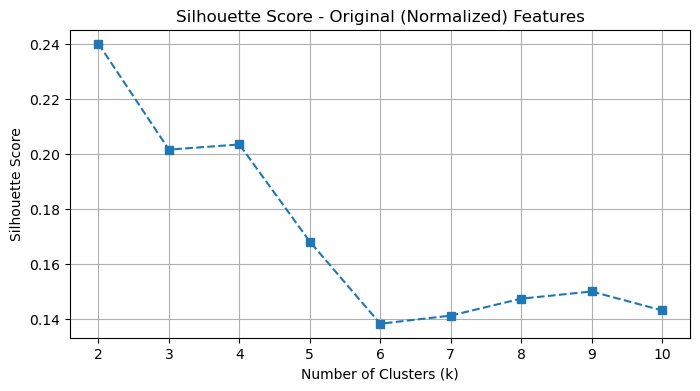

C:\Users\schiltem93\AppData\Local\anaconda3\envs\analytics2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\schiltem93\AppData\Local\anaconda3\envs\analytics2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\schiltem93\AppData\Local\anaconda3\envs\analytics2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\schiltem93\Ap

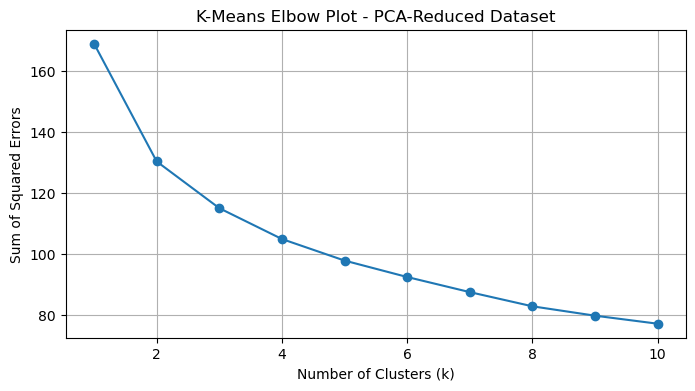

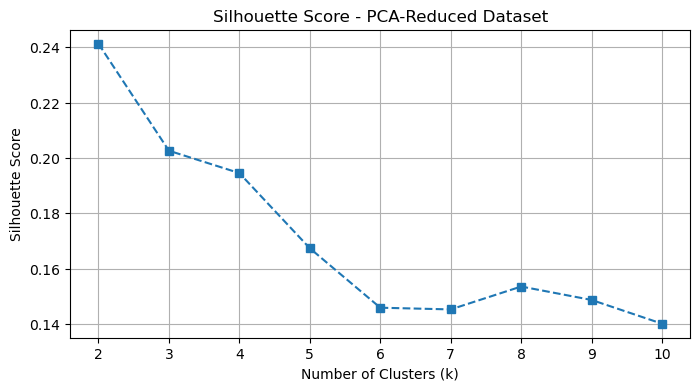

In [8]:
#1 
# Select original (normalized) variables (excluding Outcome)
original_features = df.drop(columns=["Outcome"])

# Select PCA-transformed features (excluding Outcome)
pca_features = df_pca.drop(columns=["Outcome"])

# Function to run K-Means for different values of k and store SSE & Silhouette Scores
def kmeans_evaluation(data, title):
    sse = []  # Sum of Squared Errors
    silhouette_scores = []  # Silhouette Scores
    k_values = range(1, 11)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)  # SSE
        
        # Silhouette Score is only valid for k >= 2
        if k > 1:
            score = silhouette_score(data, kmeans.labels_)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(None)

    # Plot SSE (Elbow Method)
    plt.figure(figsize=(8, 4))
    plt.plot(k_values, sse, marker='o', linestyle='-', label="SSE")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Sum of Squared Errors")
    plt.title(f"K-Means Elbow Plot - {title}")
    plt.grid()
    plt.show()

    # Plot Silhouette Scores
    plt.figure(figsize=(8, 4))
    plt.plot(k_values[1:], silhouette_scores[1:], marker='s', linestyle='--', label="Silhouette Score")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title(f"Silhouette Score - {title}")
    plt.grid()
    plt.show()

    return sse, silhouette_scores

# Run K-Means evaluation for both datasets
sse_original, silhouette_original = kmeans_evaluation(original_features, "Original (Normalized) Features")
sse_pca, silhouette_pca = kmeans_evaluation(pca_features, "PCA-Reduced Dataset")

C:\Users\schiltem93\AppData\Local\anaconda3\envs\analytics2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\schiltem93\AppData\Local\anaconda3\envs\analytics2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


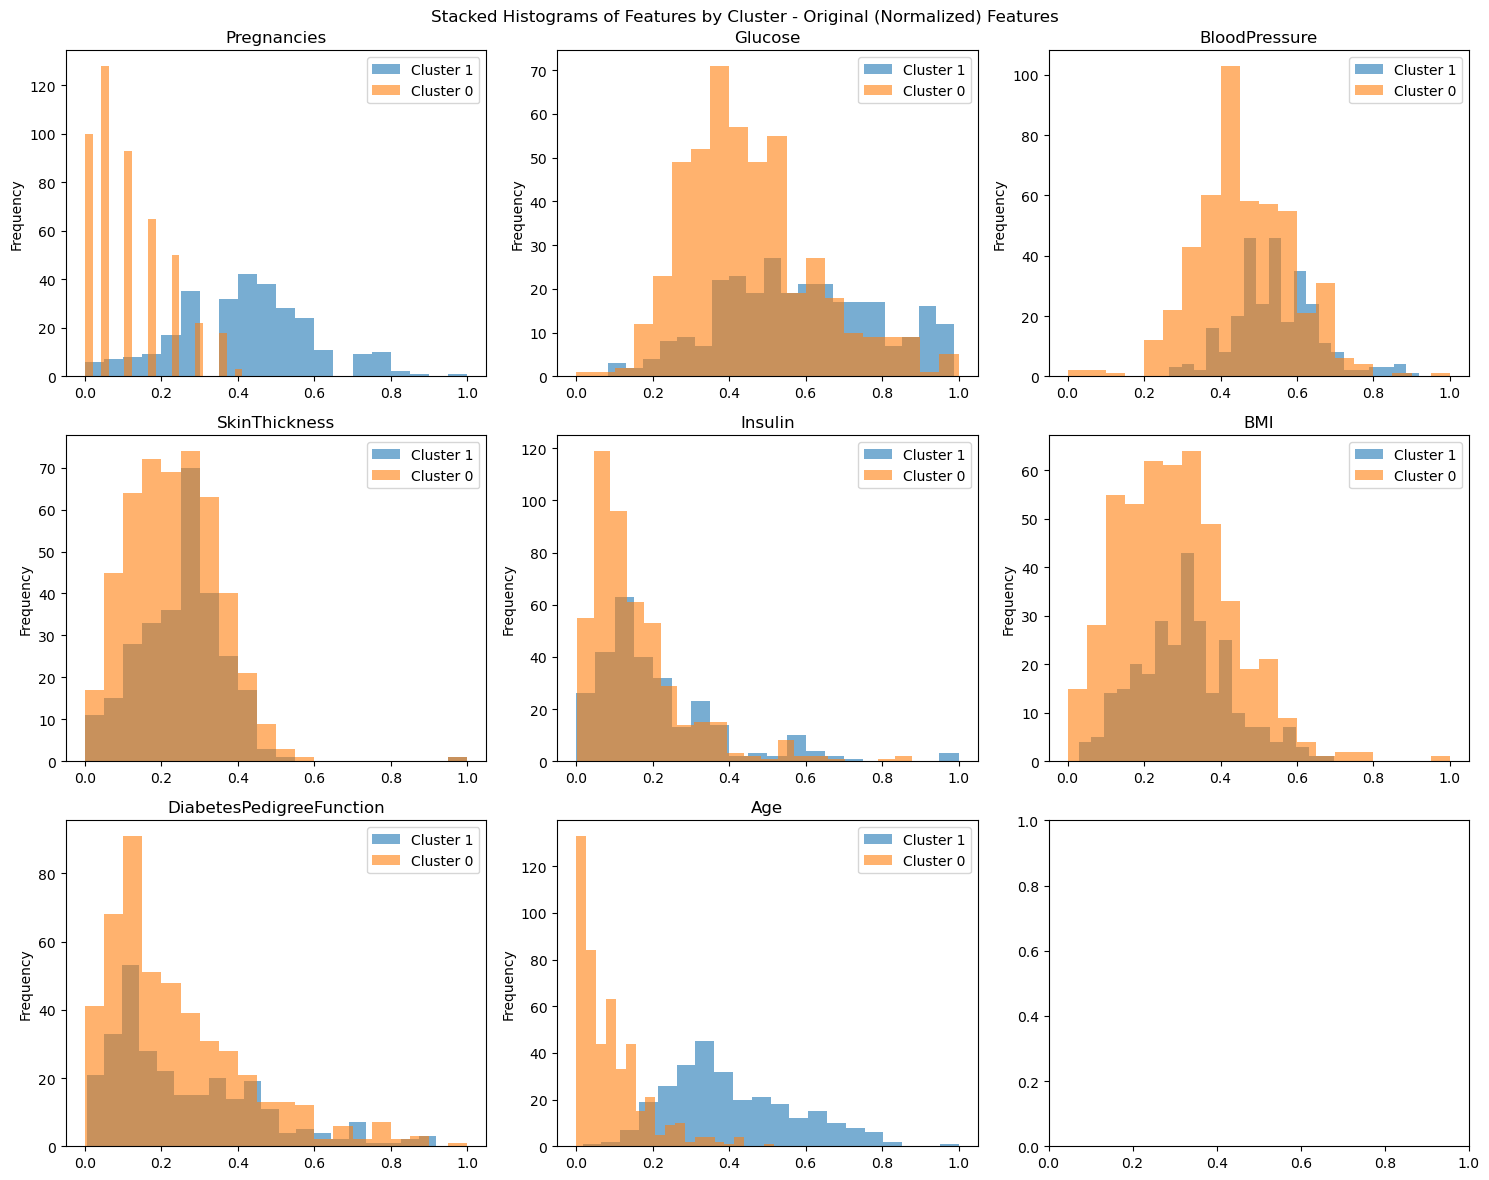

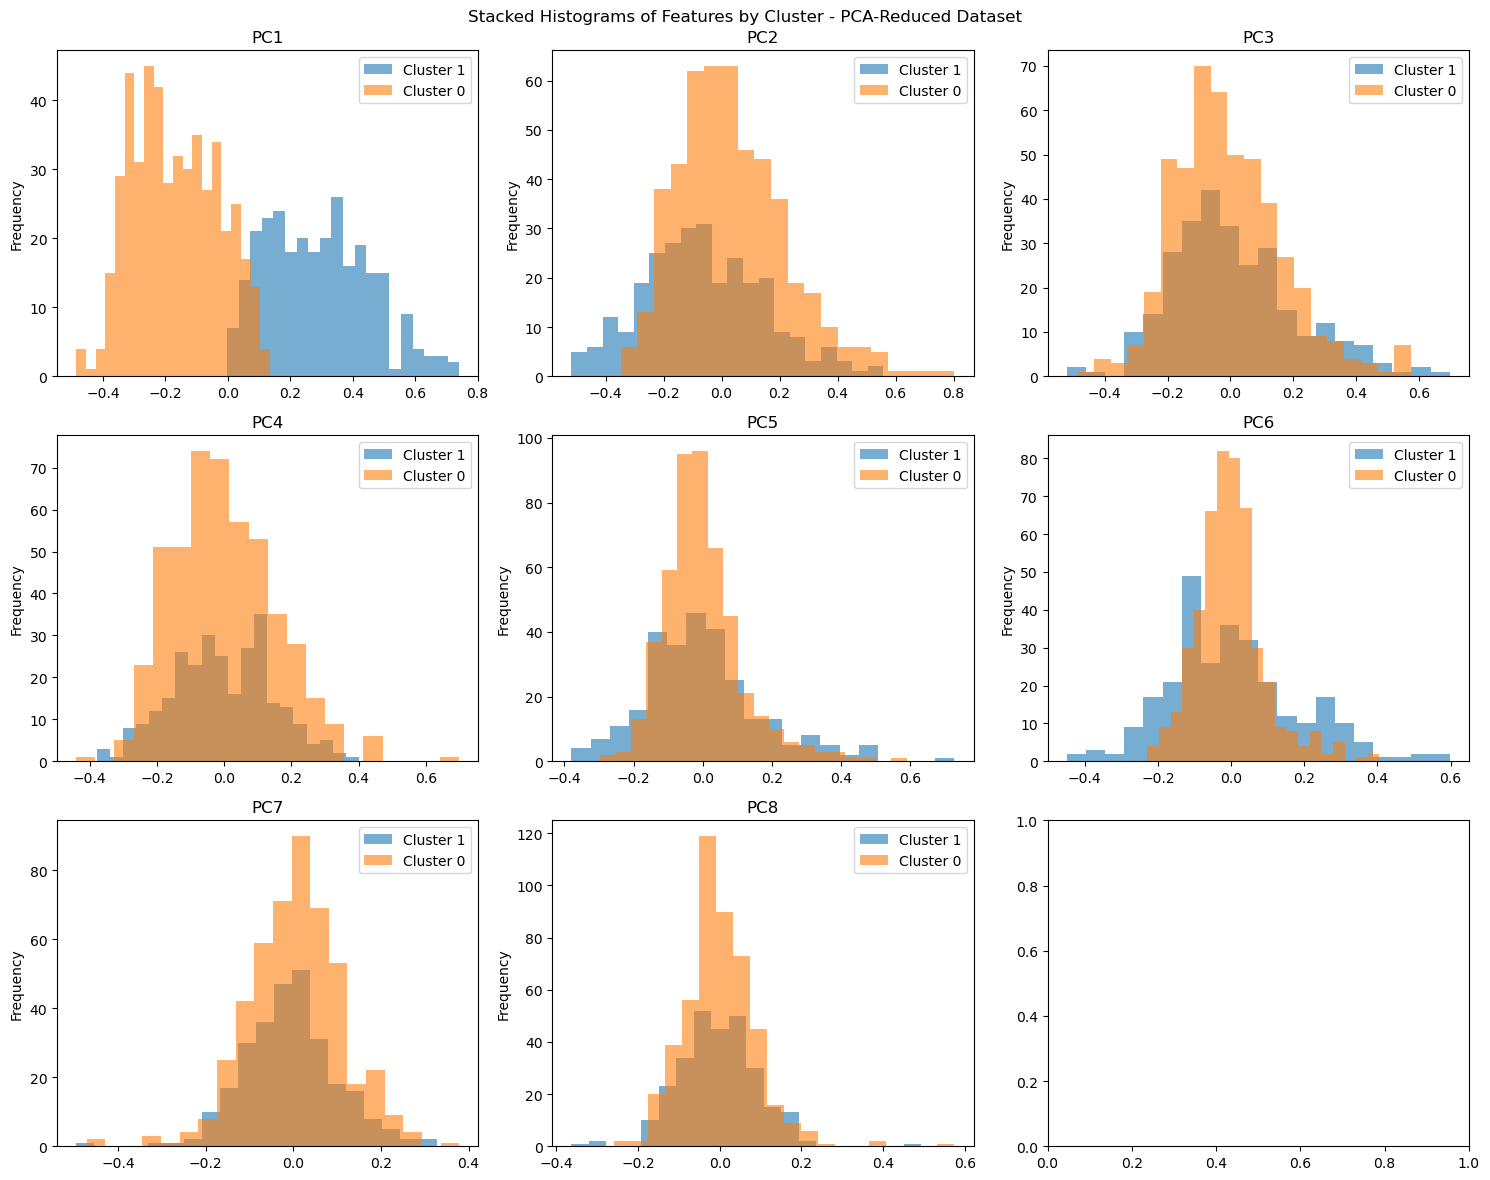

In [9]:
# Run K-Means with k=2 for both datasets
kmeans_original = KMeans(n_clusters=2, random_state=42, n_init=10)
df["Cluster_Original"] = kmeans_original.fit_predict(original_features)

kmeans_pca = KMeans(n_clusters=2, random_state=42, n_init=10)
df_pca["Cluster_PCA"] = kmeans_pca.fit_predict(pca_features)

def plot_stacked_histograms(df, cluster_col, title):
    # Select only numeric columns
    numeric_features = df.select_dtypes(include=[np.number]).columns
    features = [col for col in numeric_features if col not in ["Outcome", cluster_col]]  # Exclude Outcome & cluster column
    num_features = len(features)

    if num_features == 0:
        print(f"No numeric features available for plotting in {title}")
        return

    # Define the grid layout for subplots
    fig, axes = plt.subplots(nrows=int(np.ceil(num_features / 3)), ncols=3, figsize=(15, num_features * 1.5))
    axes = axes.flatten()

    # Iterate through each feature and plot a histogram
    for i, feature in enumerate(features):
        for cluster in df[cluster_col].unique():
            subset = df[df[cluster_col] == cluster]
            axes[i].hist(subset[feature], bins=20, alpha=0.6, label=f"Cluster {cluster}", stacked=True)
        
        axes[i].set_title(feature)
        axes[i].set_ylabel("Frequency")
        axes[i].legend()
    
    # Adjust layout
    plt.suptitle(f"Stacked Histograms of Features by Cluster - {title}")
    plt.tight_layout()
    plt.show()

# Plot stacked histograms for original features
plot_stacked_histograms(df, "Cluster_Original", "Original (Normalized) Features")

# Plot stacked histograms for PCA-reduced dataset
plot_stacked_histograms(df_pca, "Cluster_PCA", "PCA-Reduced Dataset")

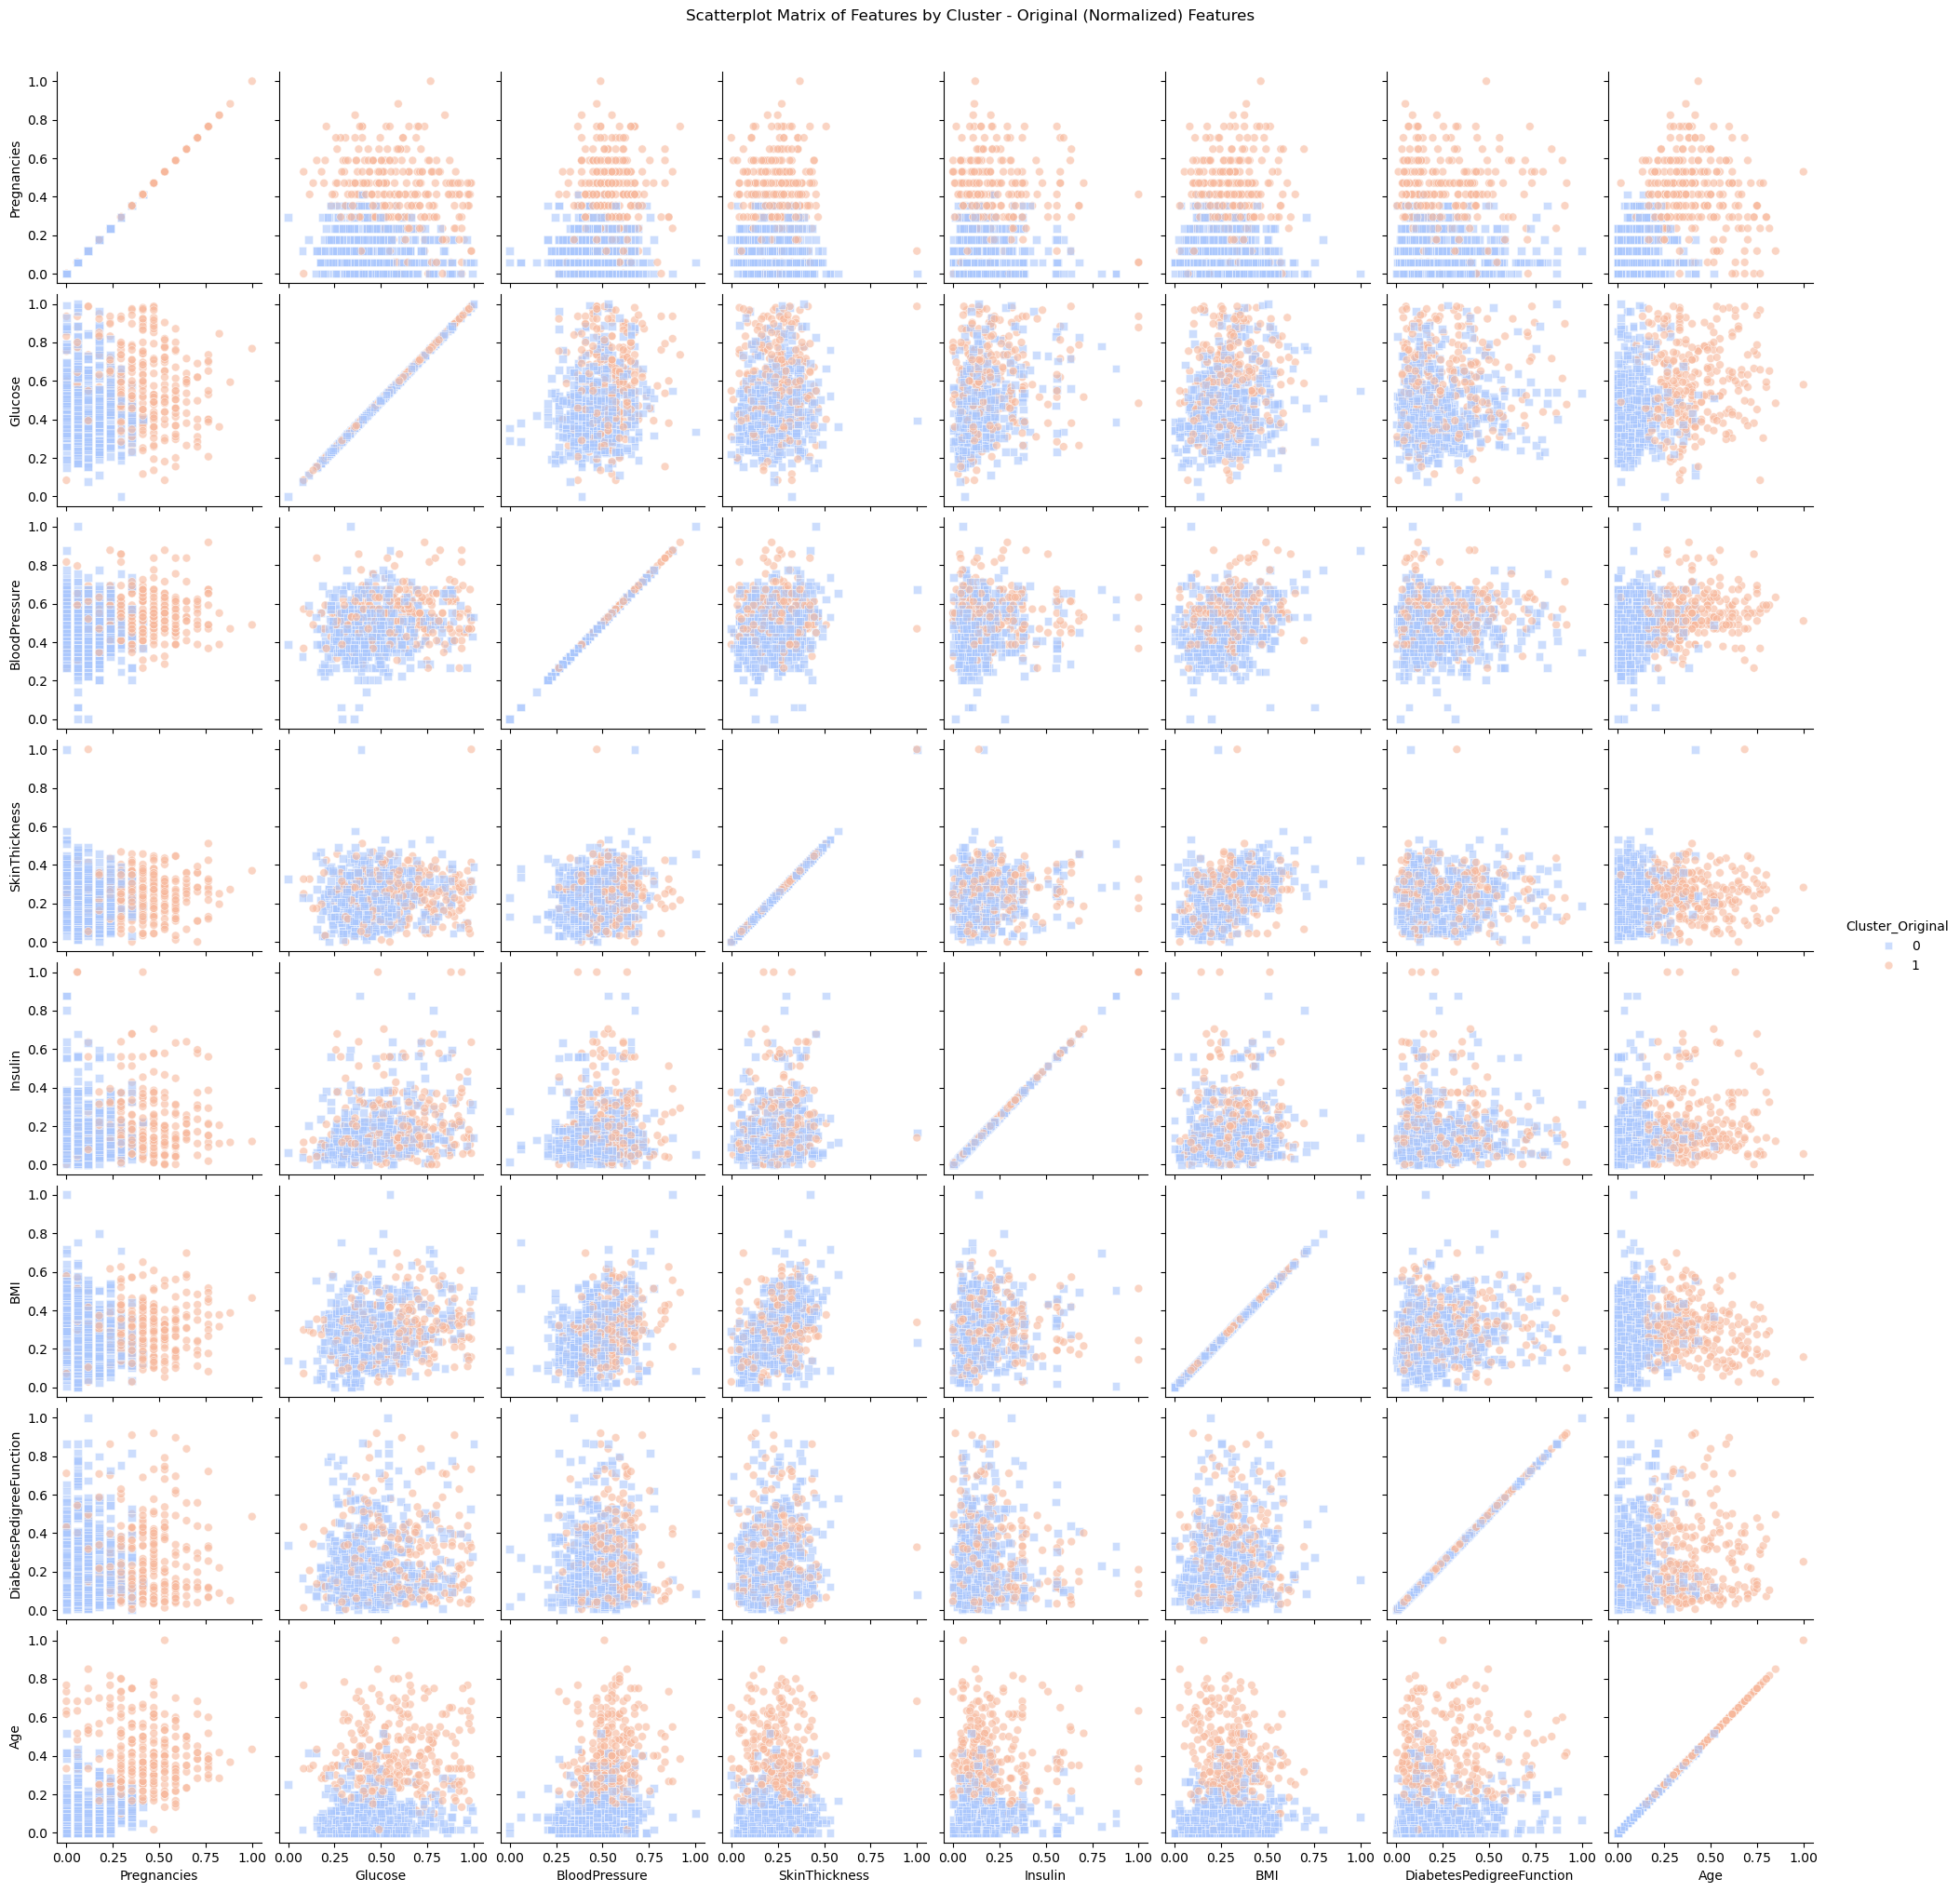

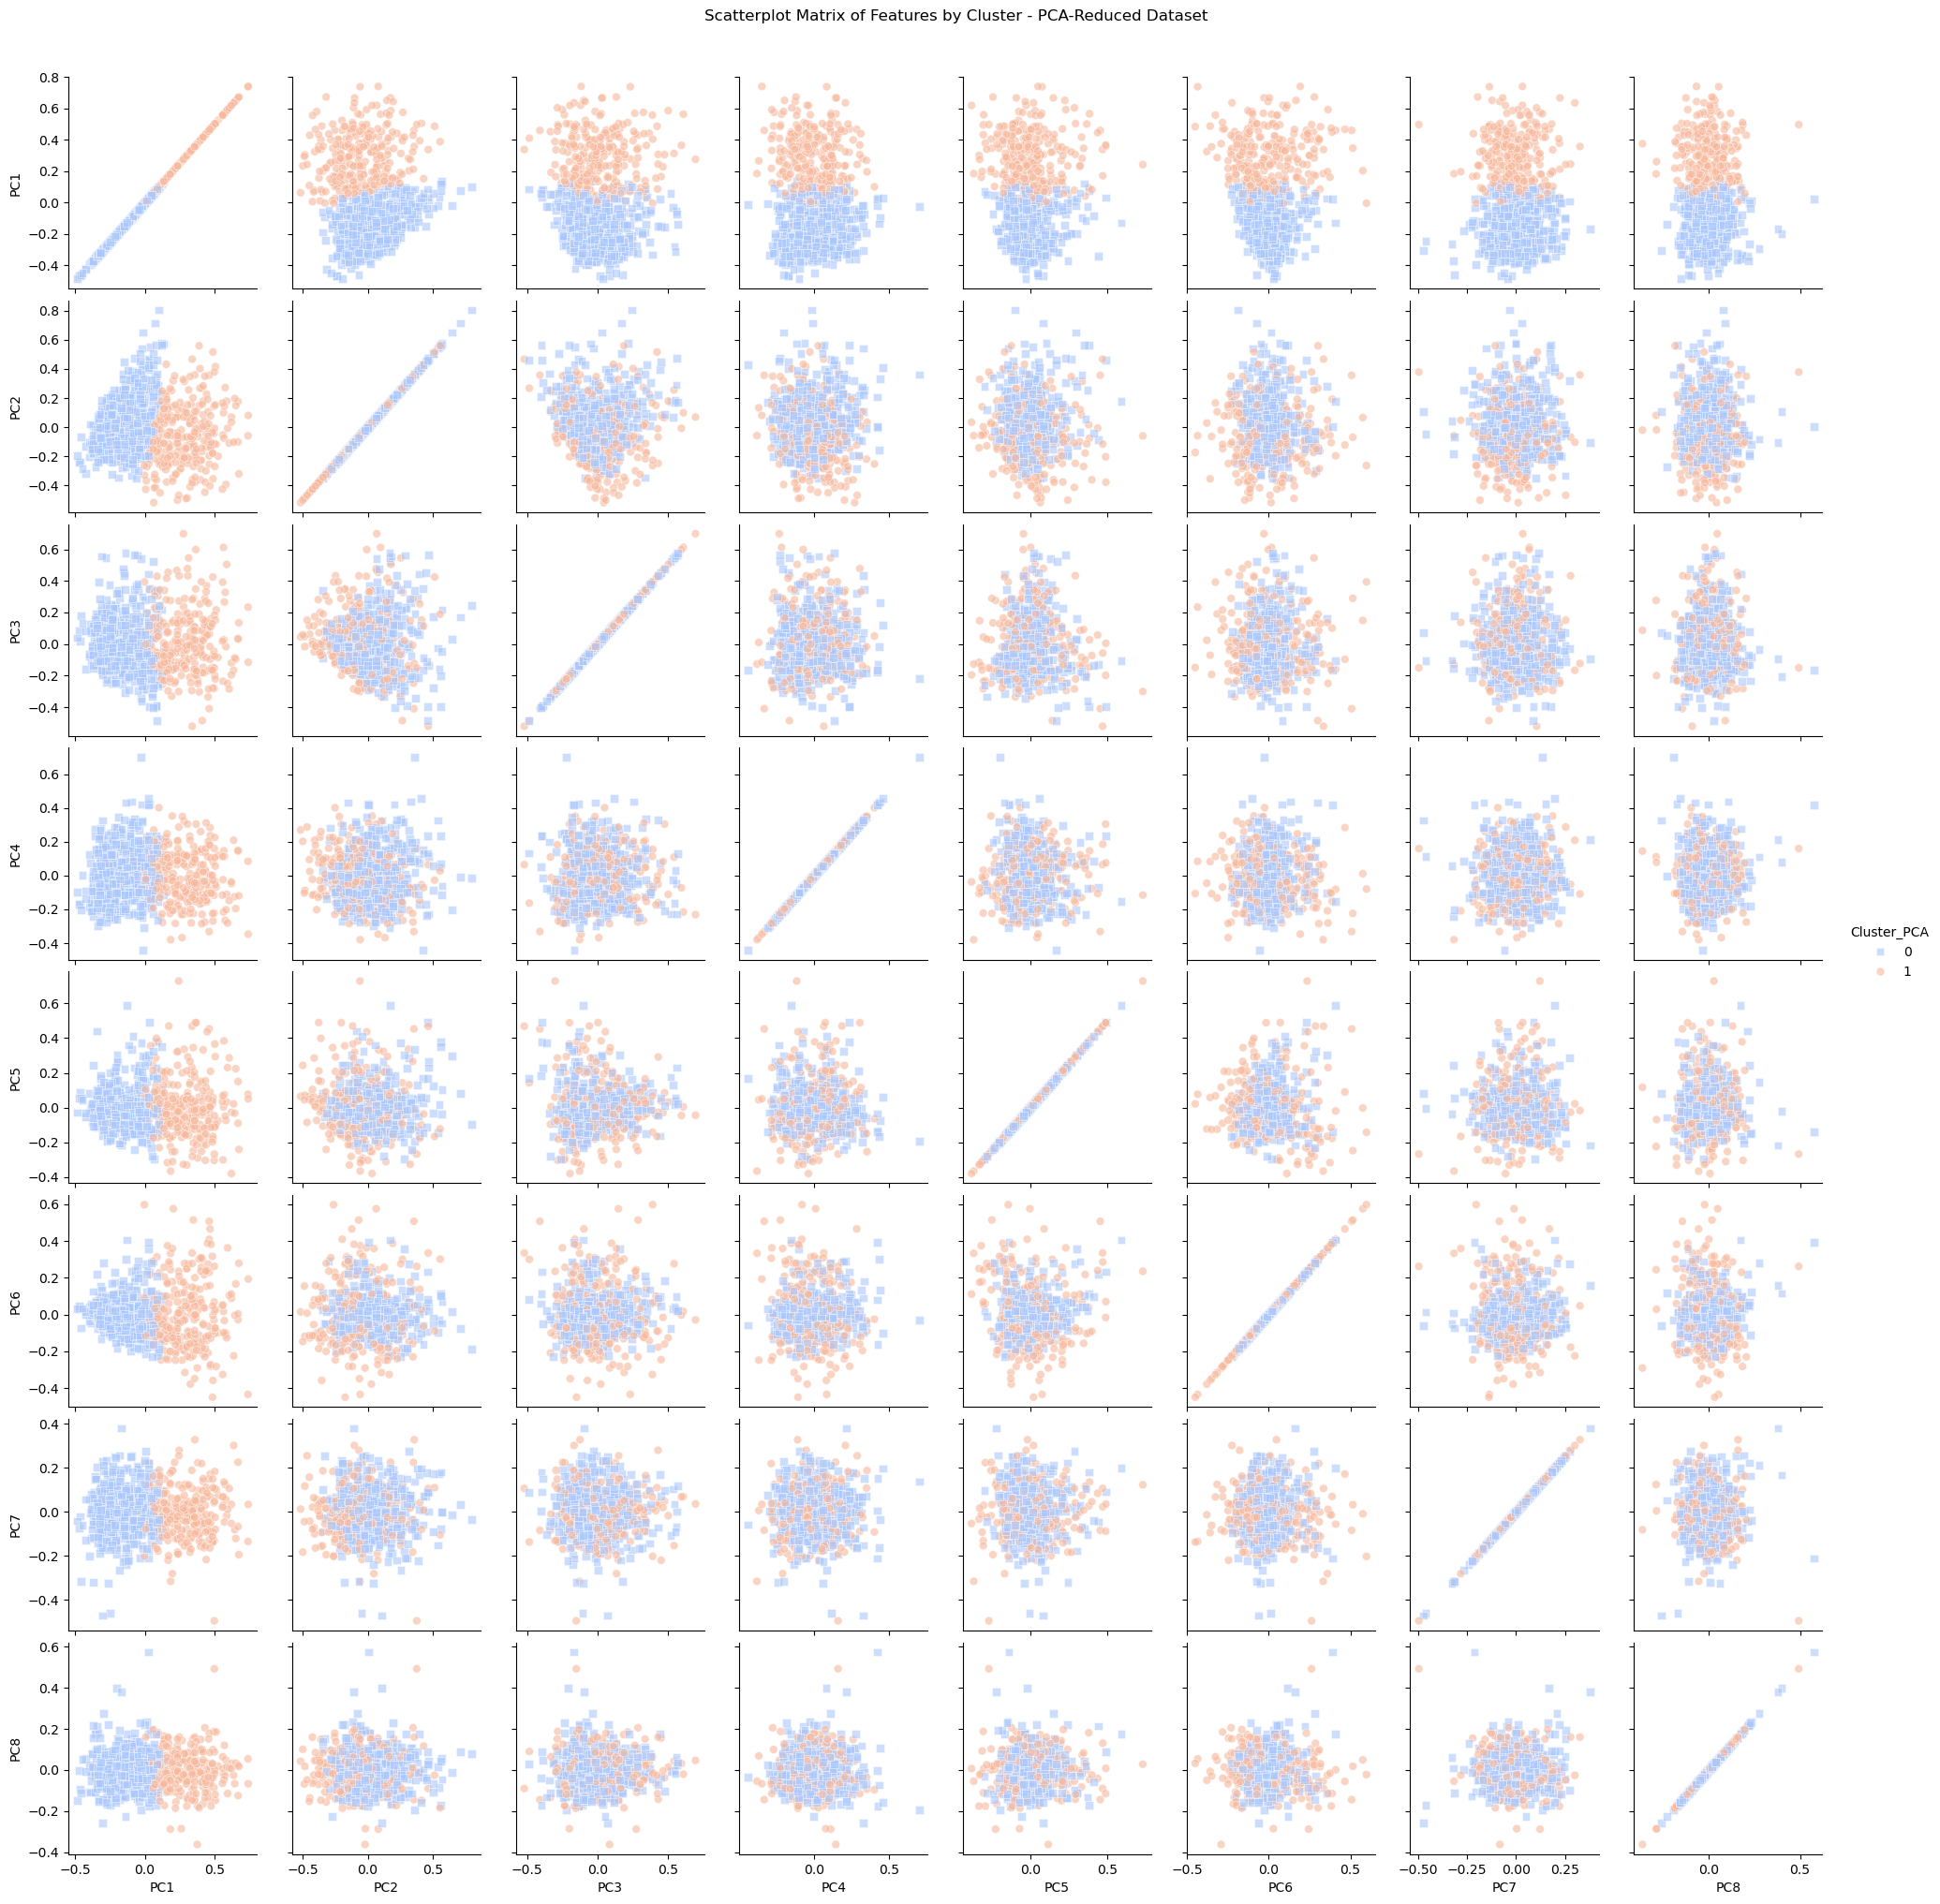

In [10]:
def plot_scatter_matrix(df, cluster_col, title):
    # Define marker styles based on Outcome
    markers = {0: "o", 1: "s"}  # Circle for non-diabetic, Square for diabetic
    
    # Select only feature columns (exclude Outcome and Outlier-related columns)
    selected_features = df.drop(columns=["Outcome", cluster_col, "outlier_Tukey", "outlier_z_score"], errors="ignore")

    # Create scatterplot matrix using seaborn
    g = sns.pairplot(
        df, 
        hue=cluster_col,  # Color by cluster
        diag_kind=None,  # No histograms on the diagonal
        palette="coolwarm",
        markers=[markers[outcome] for outcome in df["Outcome"].unique()],  # Different shapes for Outcome
        vars=selected_features.columns,  # Exclude Outcome from the plots
        plot_kws={"alpha": 0.6, "s": 40}  # Transparency and point size
    )
    
    plt.suptitle(f"Scatterplot Matrix of Features by Cluster - {title}", y=1.02)
    plt.show()

# Plot scatterplot matrix for original features (excluding outliers)
plot_scatter_matrix(df, "Cluster_Original", "Original (Normalized) Features")

# Plot scatterplot matrix for PCA-reduced dataset (excluding outliers)
plot_scatter_matrix(df_pca, "Cluster_PCA", "PCA-Reduced Dataset")

#### Task Kohonen Self-Organizing Maps

Perform the following tasks for the original (but normalized) variables.
1) Train a SOM on the input variables.
2) Visualize the SOM using U-matrix and highlighting the neighbourhood distance. Calculate the Quantization Error (average Euclidean of each data point and its BMU).
3) Vary the SOM parameters. How do changes in grid size,  learning rate, sigma (spread of the neighbourhood function) and topology affect the U-matrix/Quantization Error? Which parameters do you see as the best fit for the data?
4) Based on your preferred parameters, Label the data points by the cluster assignment of their BMU.
5) Compare if the clusters align with the outcome.
6) Compare if the clusters align with the two versions of clusters (original data & dimensionality-reduced data) created by K-Means Clustering.

In [11]:
# 1)

# Prepare input data (exclude Outcome and outlier columns)
X = df.drop(columns=["Outcome", "outlier_Tukey", "outlier_z_score"], errors="ignore").values

# Determine grid size using heuristic: ~5*sqrt(n) neurons
n_samples = X.shape[0]
grid_size = int(np.sqrt(5 * np.sqrt(n_samples)))  # Approximate SOM size

# Initialize and train SOM
som = MiniSom(grid_size, grid_size, X.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)
som.random_weights_init(X)
som.train_random(X, 1000)  # Train for 1000 iterations


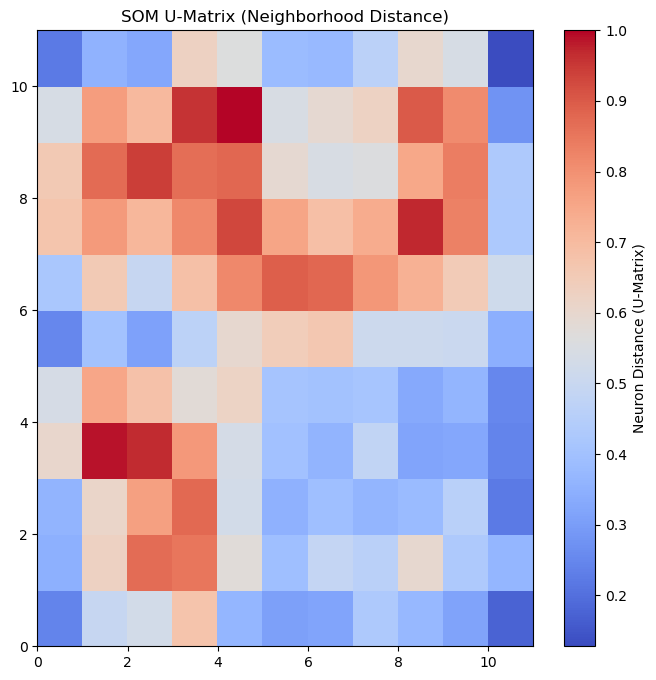

Quantization Error: 0.2168


In [12]:
# 2)
# Calculate the U-Matrix (neighborhood distance visualization)
plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap="coolwarm")  # U-matrix visualization
plt.colorbar(label="Neuron Distance (U-Matrix)")
plt.title("SOM U-Matrix (Neighborhood Distance)")
plt.show()

# Calculate Quantization Error (Average Euclidean distance to BMU)
quantization_errors = np.mean([np.linalg.norm(x - som.get_weights()[som.winner(x)]) for x in X])

print(f"Quantization Error: {quantization_errors:.4f}")



Training SOM with Grid: 2x2, Learning Rate: 0.5, Sigma: 1.0, Topology: rectangular


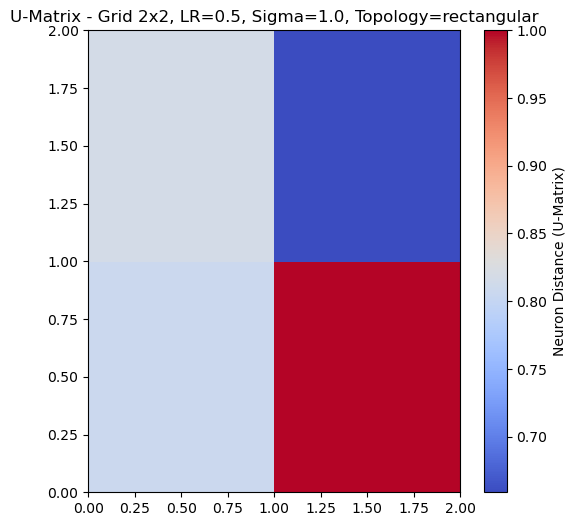

Quantization Error: 0.3835

Training SOM with Grid: 7x7, Learning Rate: 0.5, Sigma: 1.0, Topology: rectangular


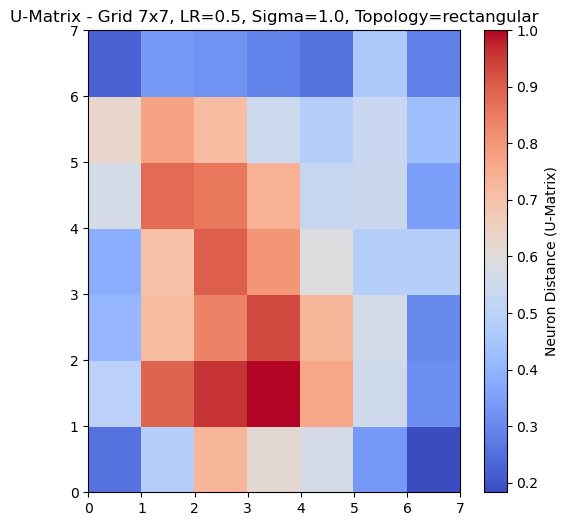

Quantization Error: 0.2517

Training SOM with Grid: 20x20, Learning Rate: 0.5, Sigma: 1.0, Topology: rectangular


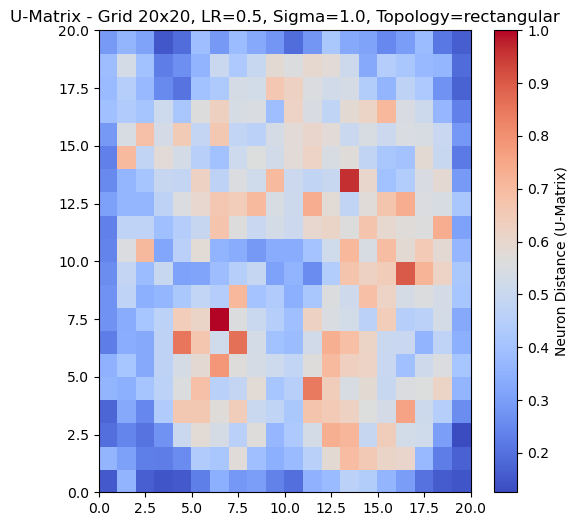

Quantization Error: 0.1823

Training SOM with Grid: 7x7, Learning Rate: 0.1, Sigma: 1.0, Topology: rectangular


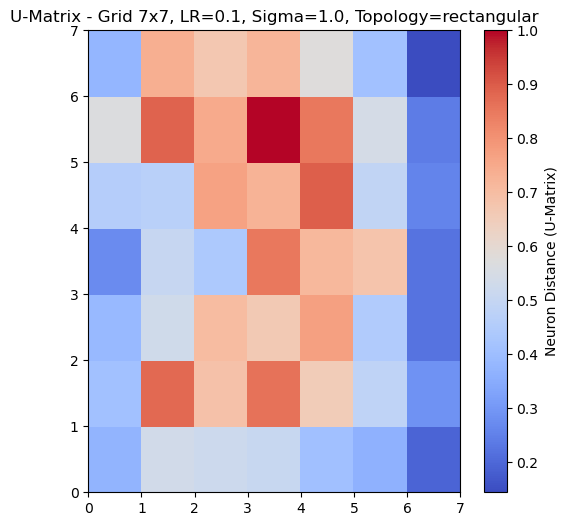

Quantization Error: 0.2736

Training SOM with Grid: 7x7, Learning Rate: 0.5, Sigma: 1.0, Topology: rectangular


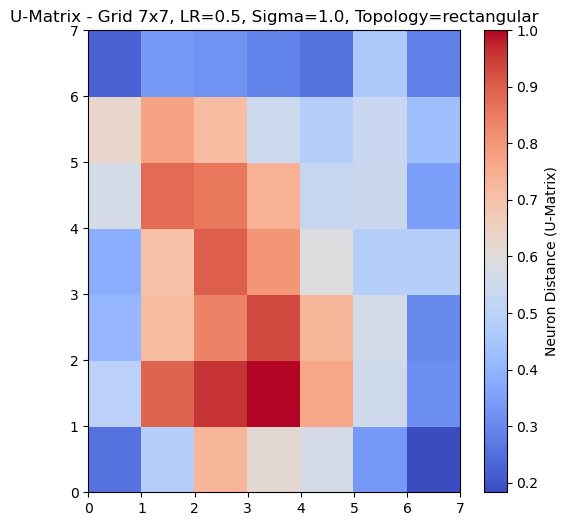

Quantization Error: 0.2517

Training SOM with Grid: 7x7, Learning Rate: 0.9, Sigma: 1.0, Topology: rectangular


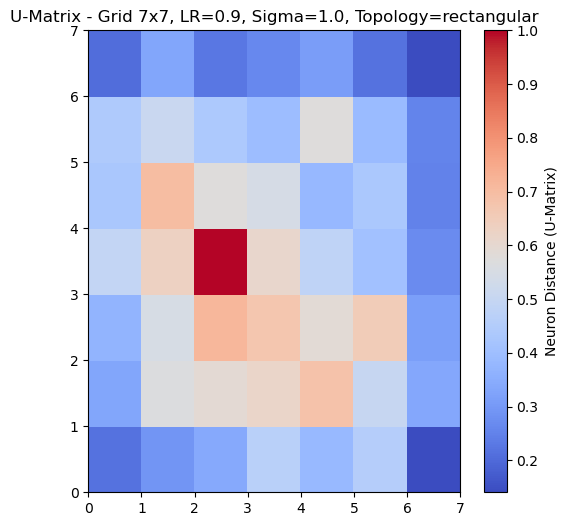

Quantization Error: 0.2599

Training SOM with Grid: 7x7, Learning Rate: 0.5, Sigma: 0.5, Topology: rectangular


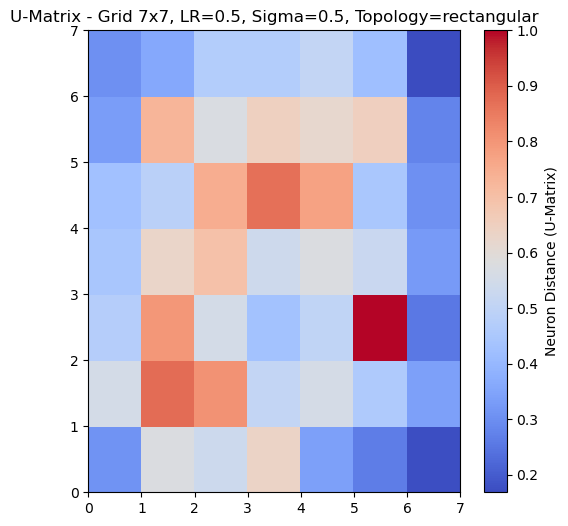

Quantization Error: 0.2591

Training SOM with Grid: 7x7, Learning Rate: 0.5, Sigma: 1.0, Topology: rectangular


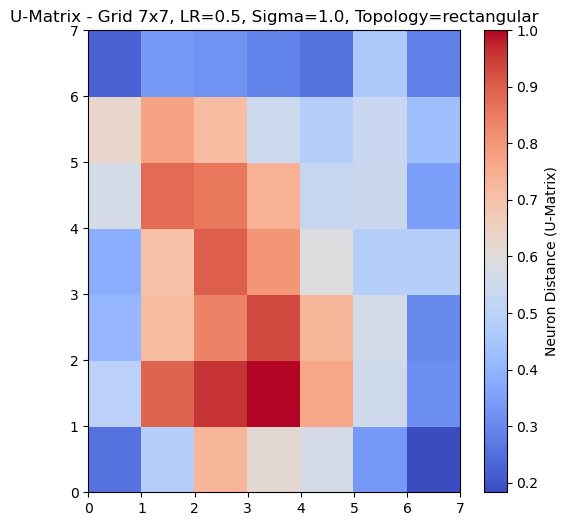

Quantization Error: 0.2517

Training SOM with Grid: 7x7, Learning Rate: 0.5, Sigma: 2.0, Topology: rectangular


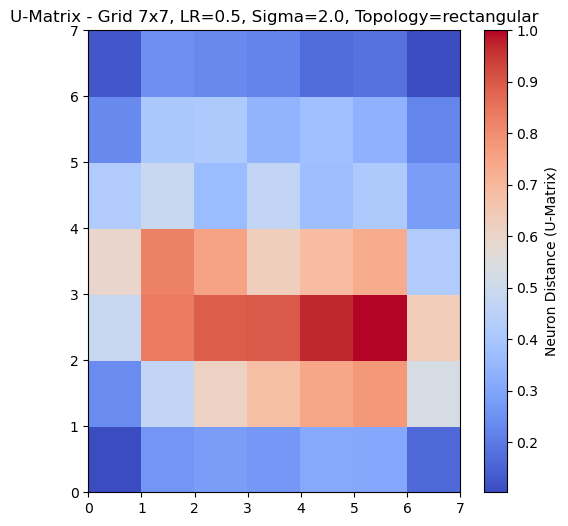

Quantization Error: 0.2773

Training SOM with Grid: 7x7, Learning Rate: 0.5, Sigma: 1.0, Topology: rectangular


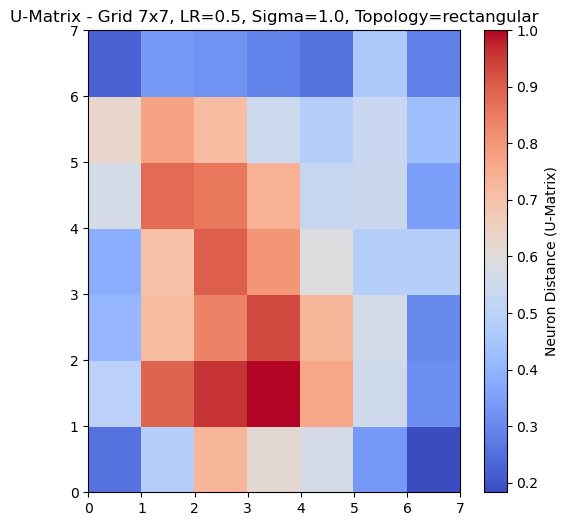

Quantization Error: 0.2517

Training SOM with Grid: 7x7, Learning Rate: 0.5, Sigma: 1.0, Topology: hexagonal


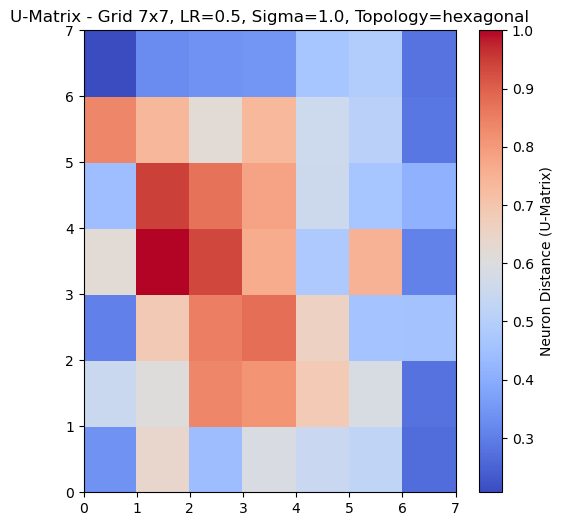

Quantization Error: 0.2525


In [13]:
# 3)
# Function to train SOM and compute QE
def train_som(grid_x, grid_y, lr, sigma, topology="rectangular"):
    print(f"\nTraining SOM with Grid: {grid_x}x{grid_y}, Learning Rate: {lr}, Sigma: {sigma}, Topology: {topology}")
    
    # Initialize SOM
    som = MiniSom(grid_x, grid_y, X.shape[1], sigma=sigma, learning_rate=lr, topology=topology, random_seed=42)
    som.random_weights_init(X)
    som.train_random(X, 1000)  # Train for 1000 iterations

    # Plot U-Matrix
    plt.figure(figsize=(6, 6))
    plt.pcolor(som.distance_map().T, cmap="coolwarm")
    plt.colorbar(label="Neuron Distance (U-Matrix)")
    plt.title(f"U-Matrix - Grid {grid_x}x{grid_y}, LR={lr}, Sigma={sigma}, Topology={topology}")
    plt.show()

    weights = som.get_weights()


    # Calculate Quantization Error
    qe = np.mean([np.linalg.norm(x - weights[som.winner(x)]) for x in X])
    print(f"Quantization Error: {qe:.4f}")
    
    return qe

# Vary Grid Size
grid_sizes = [(2, 2), (7, 7), (20, 20)]
qe_grid = [train_som(gx, gy, lr=0.5, sigma=1.0) for gx, gy in grid_sizes]

# Vary Learning Rate
learning_rates = [0.1, 0.5, 0.9]
qe_lr = [train_som(7, 7, lr, sigma=1.0) for lr in learning_rates]

# Vary Sigma
sigmas = [0.5, 1.0, 2.0]
qe_sigma = [train_som(7, 7, lr=0.5, sigma=s) for s in sigmas]

# Vary Topology
topologies = ["rectangular", "hexagonal"]
qe_topology = [train_som(7, 7, lr=0.5, sigma=1.0, topology=t) for t in topologies]

C:\Users\schiltem93\AppData\Local\anaconda3\envs\analytics2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


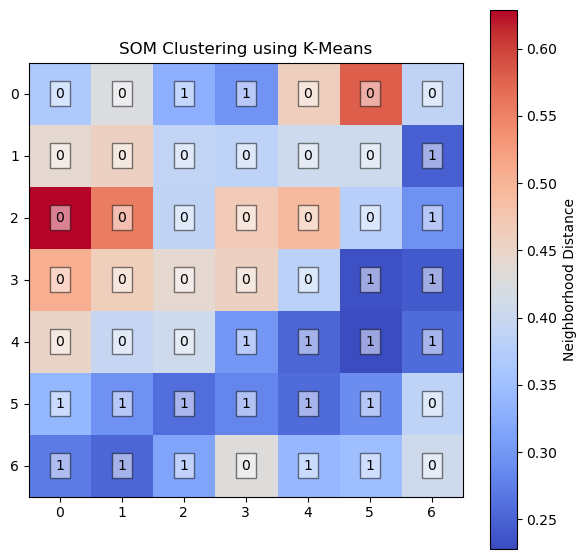

In [14]:
# 4)
# Define SOM parameters
grid_x, grid_y = 7, 7
som = MiniSom(grid_x, grid_y, X.shape[1], sigma=1.0, learning_rate=0.5, topology="rectangular", random_seed=42)

# Initialize and train SOM
som.random_weights_init(X)
som.train_random(X, 1000)

# Compute the neighborhood distance of all nodes
u_matrix = np.zeros((grid_x, grid_y))
for i in range(grid_x):
    for j in range(grid_y):
        neighbors = []
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # 4-neighborhood
            if 0 <= i + dx < grid_x and 0 <= j + dy < grid_y:
                neighbors.append(som.get_weights()[i + dx, j + dy])
        
        u_matrix[i, j] = np.mean([np.linalg.norm(som.get_weights()[i, j] - n) for n in neighbors])

# Reshape for clustering
u_matrix_flat = u_matrix.reshape(-1, 1)

# Apply K-Means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(u_matrix_flat)

# Assign cluster labels to the data points
bmu_clusters = {}
for i in range(grid_x):
    for j in range(grid_y):
        bmu_clusters[(i, j)] = kmeans_labels[i * grid_y + j]

# Assign each data point the cluster label of its BMU
data_labels = np.array([bmu_clusters[som.winner(x)] for x in X])

# Assign cluster labels to the dataframe
df["SOM_KMeans_Cluster"] = data_labels

# Visualization of the SOM clustering
plt.figure(figsize=(7, 7))
for i in range(grid_x):
    for j in range(grid_y):
        plt.text(j, i, str(bmu_clusters[(i, j)]), ha='center', va='center', 
                 bbox=dict(facecolor='white', alpha=0.5))
plt.imshow(u_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Neighborhood Distance')
plt.title('SOM Clustering using K-Means')
plt.show()

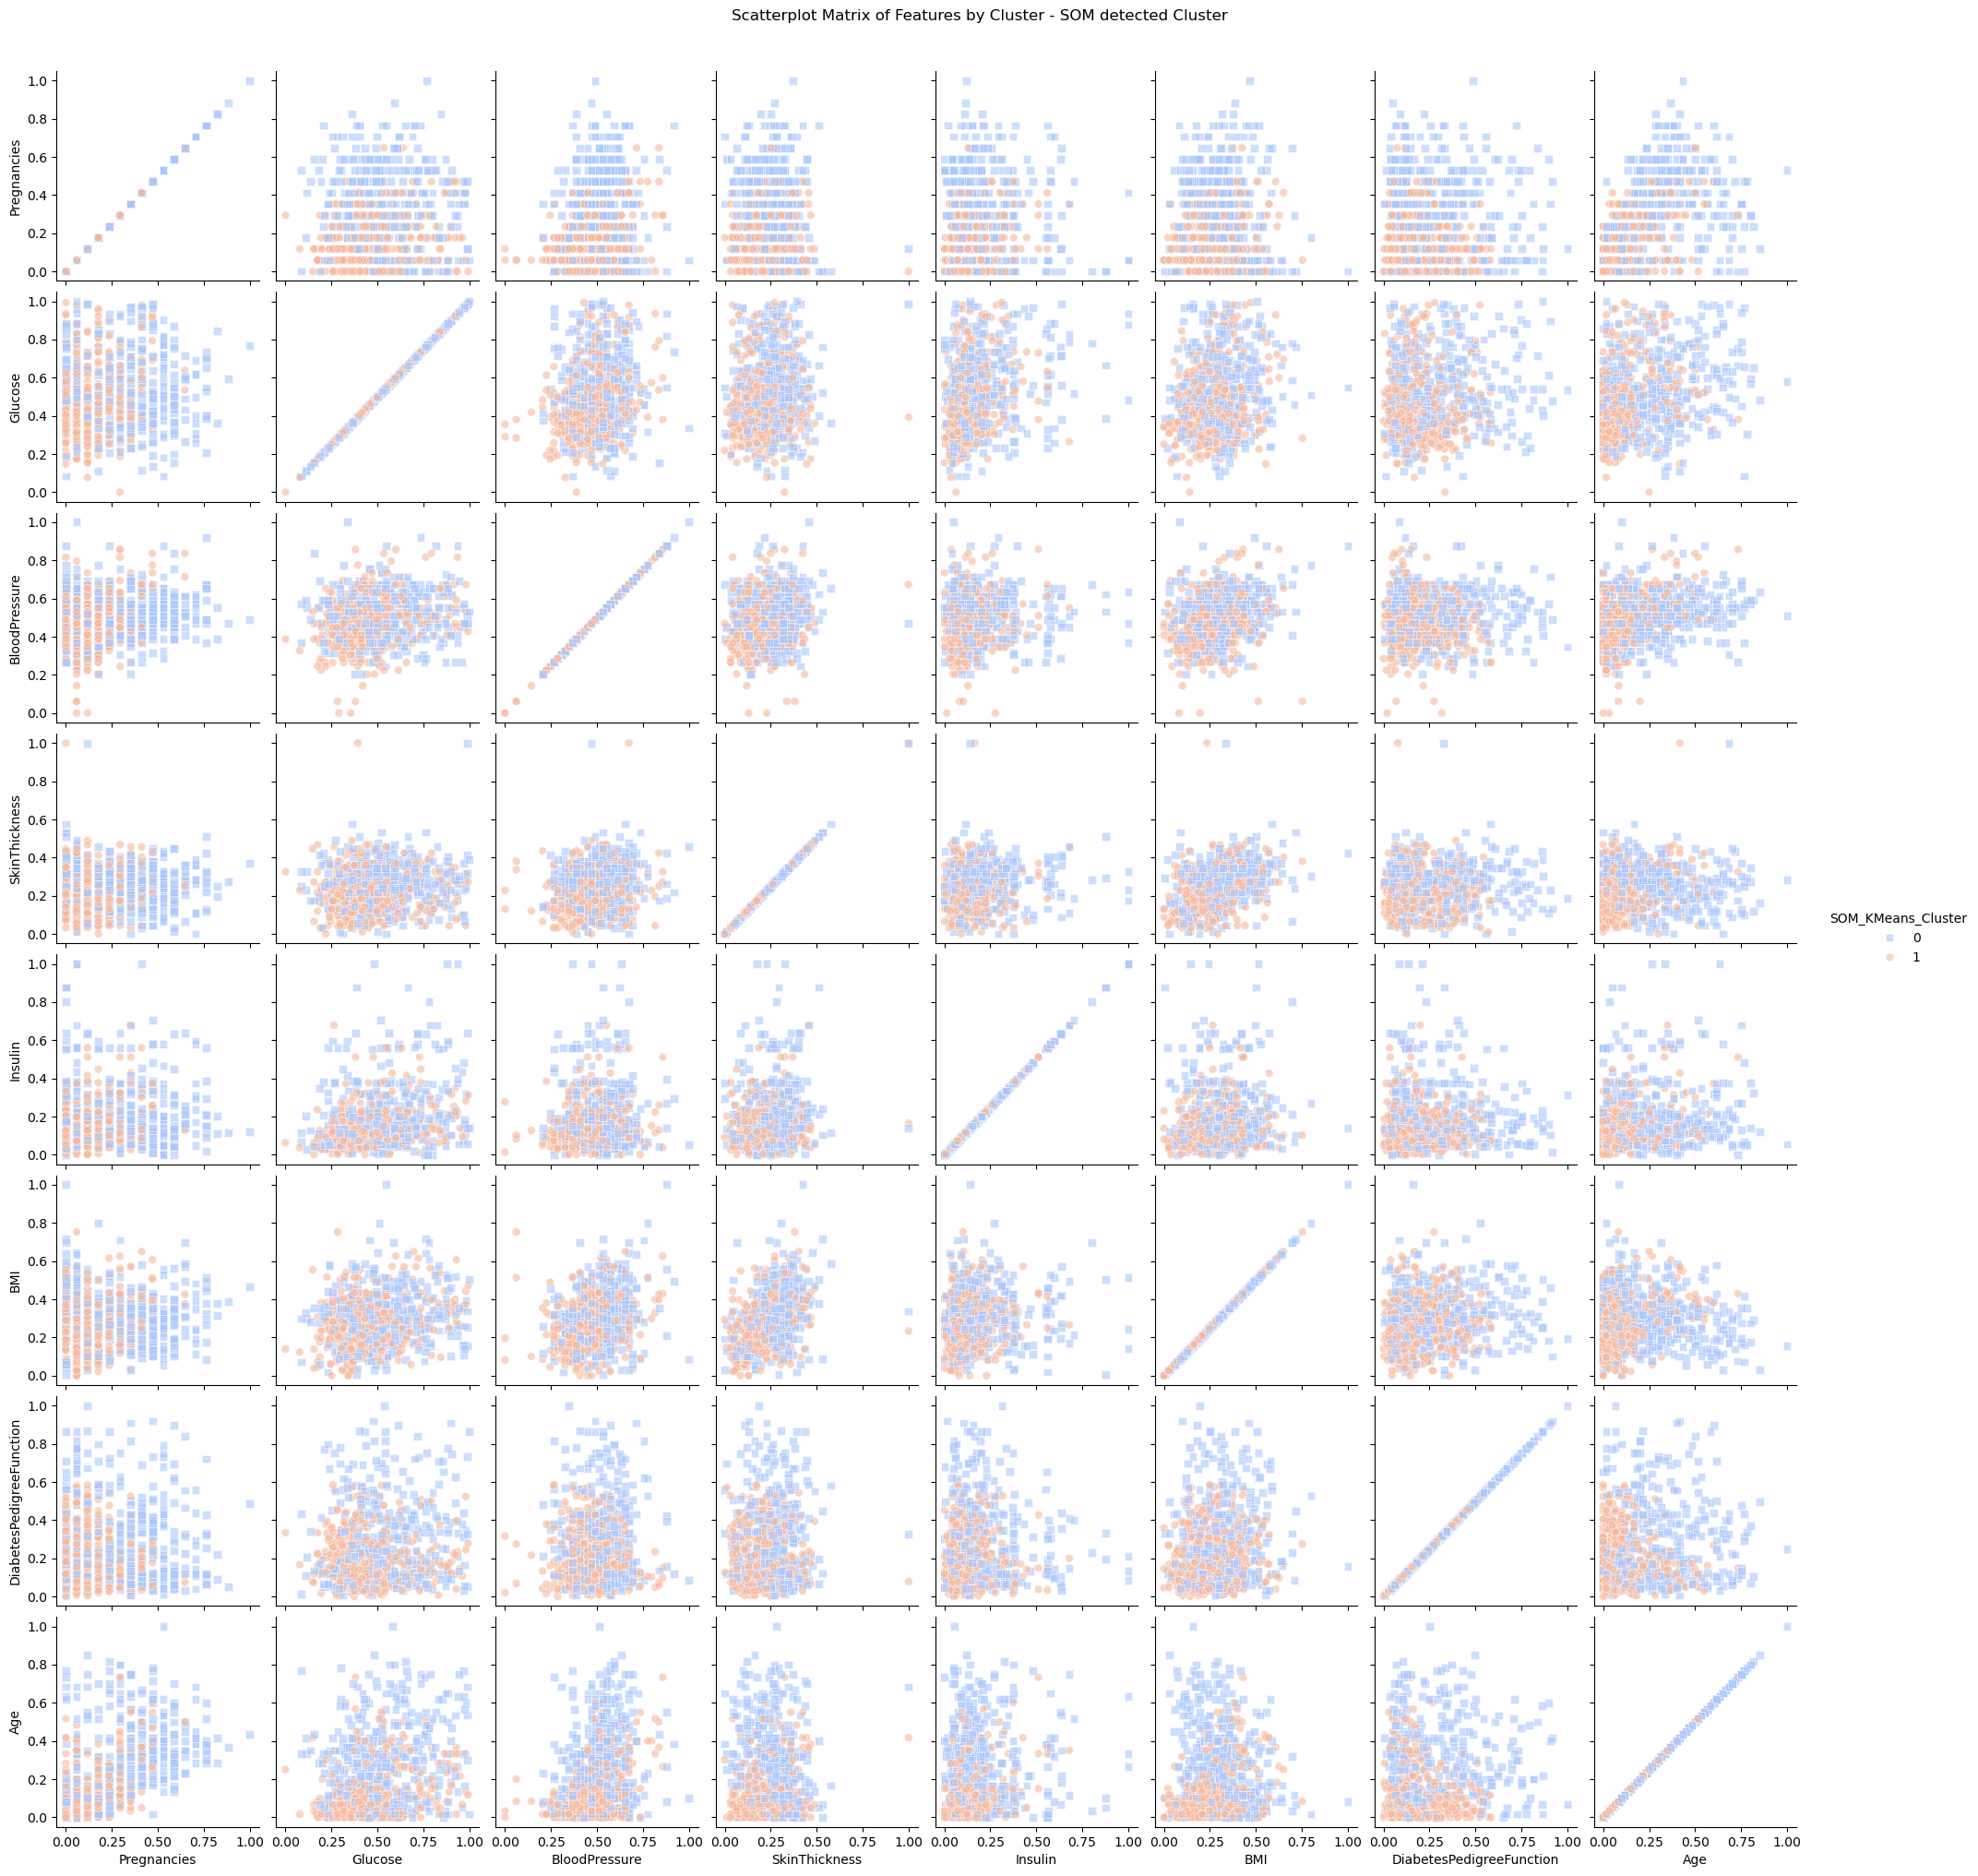

In [15]:
# 5)
def plot_scatter_matrix(df, cluster_col, title):
    # Define marker styles based on Outcome
    markers = {0: "o", 1: "s"}  # Circle for non-diabetic, Square for diabetic
    
    # Select only feature columns (exclude Outcome and Outlier-related columns)
    selected_features = df.drop(columns=["Outcome", cluster_col, "outlier_Tukey", "outlier_z_score"], errors="ignore")

    # Create scatterplot matrix using seaborn
    g = sns.pairplot(
        df, 
        hue=cluster_col,  # Color by cluster
        diag_kind=None,  # No histograms on the diagonal
        palette="coolwarm",
        markers=[markers[outcome] for outcome in df["Outcome"].unique()],  # Different shapes for Outcome
        vars=selected_features.columns,  # Exclude Outcome from the plots
        plot_kws={"alpha": 0.6, "s": 40}  # Transparency and point size
    )
    
    plt.suptitle(f"Scatterplot Matrix of Features by Cluster - {title}", y=1.02)
    plt.show()

# Plot scatterplot matrix for original features (excluding outliers)
plot_scatter_matrix(df.drop(columns=["Cluster_Original"]), "SOM_KMeans_Cluster", "SOM detected Cluster")


In [16]:
# 6)

def visualize_cluster_match(df, cluster_col1, cluster_col2):
    """
    Visualizes how many rows have identical and different cluster assignments.
    
    Parameters:
    df : DataFrame - The dataset containing the cluster columns.
    cluster_col1 : str - The first cluster column name.
    cluster_col2 : str - The second cluster column name.
    """
    # Check if columns exist
    if cluster_col1 not in df.columns or cluster_col2 not in df.columns:
        raise ValueError("One or both cluster columns are not found in the DataFrame.")

    # Count matching and non-matching cluster assignments
    df["Cluster_Match"] = df[cluster_col1] == df[cluster_col2]
    match_counts = df["Cluster_Match"].value_counts()

    # Create a bar plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x=match_counts.index, y=match_counts.values, palette=["red", "green"])
    plt.xticks([0, 1], ["Different", "Identical"])
    plt.ylabel("Number of Rows")
    plt.title(f"Comparison of {cluster_col1} vs. {cluster_col2}")
    plt.show()

    # Print raw counts
    print(match_counts)

C:\Users\schiltem93\AppData\Local\Temp\ipykernel_20448\1240053499.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=match_counts.index, y=match_counts.values, palette=["red", "green"])


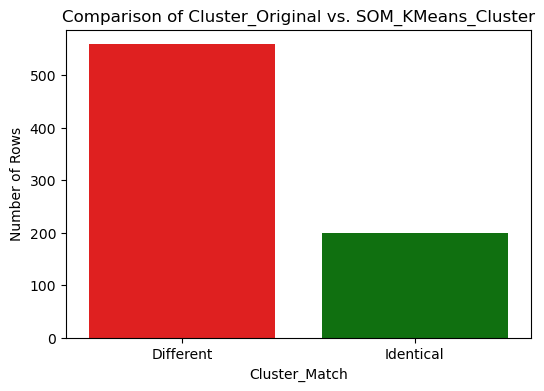

Cluster_Match
False    559
True     200
Name: count, dtype: int64


In [17]:
# compare SOM with K-means derived from original data.
visualize_cluster_match(df, "Cluster_Original", "SOM_KMeans_Cluster")

# maybe just the cluster labels didn't align...